In [15]:
import pandas as pd
import numpy as np

In [16]:
cols = ['longitude', 'prismatic_coefficient', 'length_displacement_ratio', 'beam_draught_ratio', 'length_beam_ratio', 'froude_number', 'resistance']
df = pd.read_fwf('yacht_hydrodynamics.data',
                  names=cols
                 )

In [17]:
df.head()

,longitude,prismatic_coefficient,length_displacement_ratio,beam_draught_ratio,length_beam_ratio,froude_number,resistance
0,-2.3,0.568,4.78,3.99,3.17,0.125,0.11
1,-2.3,0.568,4.78,3.99,3.17,0.150,0.27
2,-2.3,0.568,4.78,3.99,3.17,0.175,0.47
3,-2.3,0.568,4.78,3.99,3.17,0.200,0.78
4,-2.3,0.568,4.78,3.99,3.17,0.225,1.18


In [18]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, :-1].values
y = df['resistance'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [19]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [20]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    
    model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    return model

In [21]:
k = 4

num_val_samples = len(X_train) // k
num_epochs = 700
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [X_train[:i * num_val_samples],
        X_train[(i + 1) * num_val_samples:]],
        axis=0)
    
    partial_train_targets = np.concatenate(
        [y_train[:i * num_val_samples],
        y_train[(i + 1) * num_val_samples:]],
    axis=0)
    
    model = build_model()
    
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)

    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [22]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

<IPython.core.display.Javascript object>


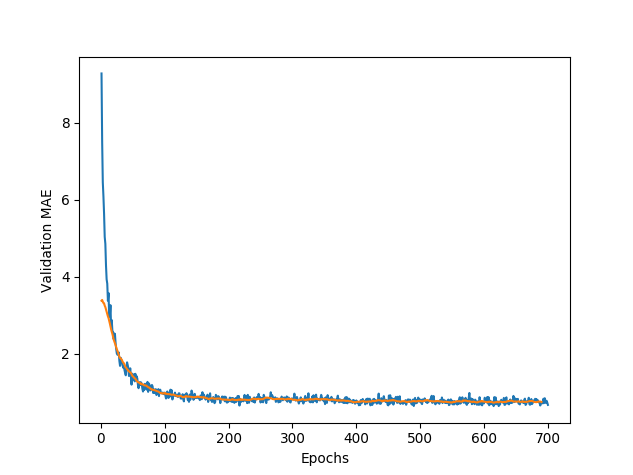

In [23]:
import matplotlib.pyplot as plt
%matplotlib notebook

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)

plt.xlabel('Epochs')
plt.ylabel('Validation MAE')

plt.show()

As we can see from the plot the optimal number of epochs will be around 200.

In [24]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
            
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)

plt.xlabel('Epochs')
plt.ylabel('Validation MAE')

plt.show()

In [28]:
model = build_model()

model.fit(X_train, y_train,
            epochs=200, batch_size=16, verbose=0)

In [29]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [30]:
from sklearn.metrics import mean_squared_error

MSE_train = mean_squared_error(y_train, y_train_pred)
MSE_test = mean_squared_error(y_test, y_test_pred)

print('MSE train: %.3f' % MSE_train)
print('MSE test: %.3f' % MSE_test)

MSE train: 0.185
MSE test: 1.151


In [31]:
from sklearn.metrics import r2_score

R2_train = r2_score(y_train, y_train_pred)
R2_test = r2_score(y_test, y_test_pred)

print('R2 train: %.3f' % R2_train)
print('R2 test: %.3f' % R2_test)

R2 train: 0.999
R2 test: 0.993


### Conclusion

We have created a neural network with 2 middle layers with 'relu' activation function.

Dense = 64:

    MSE train: 0.185
    MSE test: 1.151
    
    R2 train: 0.999
    R2 test: 0.993
    
Dense = 32:

    MSE train: 0.856
    MSE test: 2.029

    R2 train: 0.997
    R2 test: 0.988
    
Dense = 16:
    
    MSE train: 2.508
    MSE test: 3.513

    R2 train: 0.990
    R2 test: 0.980

The best result was shown by the network with dense = 64